# TUTORIAL 3:
## Pitch Control:

Building your own pitch control model in python and using it to evaluate a player's passing options. Pitch control measures the probability that a team will retain possession of the ball if they pass it to another location on the field. It can be used to evaluate passing options for a player, and quantify the probability of success.

https://www.youtube.com/watch?v=5X1cSehLg6s

close to some of the cutting edge research done in football over the last few years

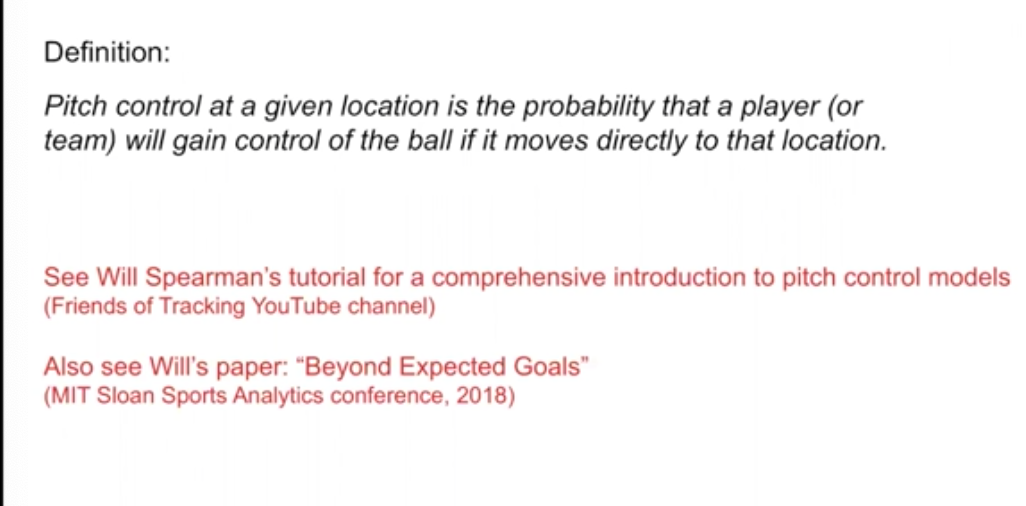

What options are available to the player with the ball?



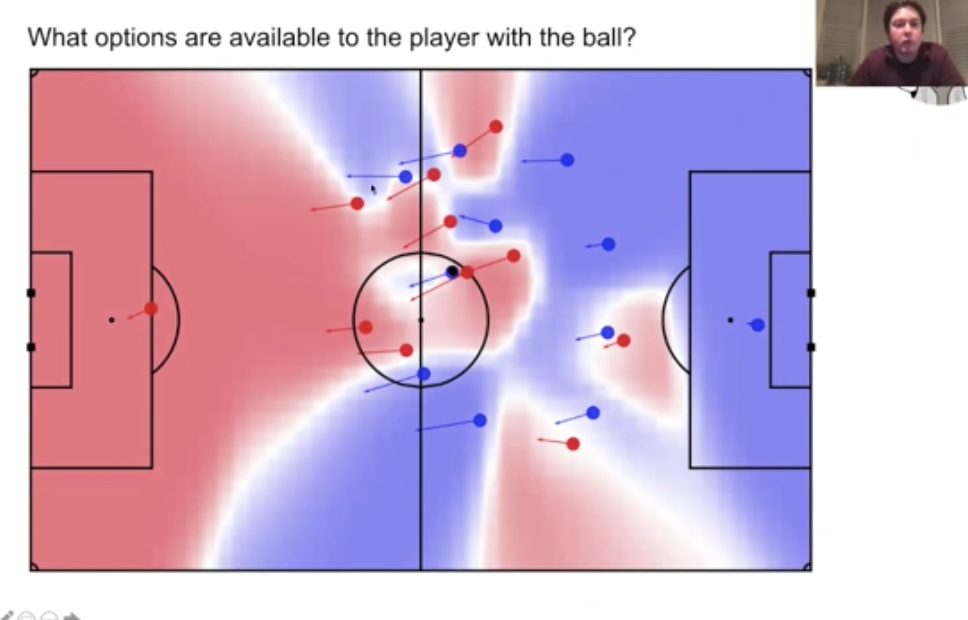

The blue player close to the middle of the pitch has control of the ball. The red zones are likelihoods that the red team will gain possession of the ball if the ball is kicked in that location and the blue zones show the likelihood that the blue team will keep possession of the ball.

This model doesn't show the `VALUE` of a potential pass

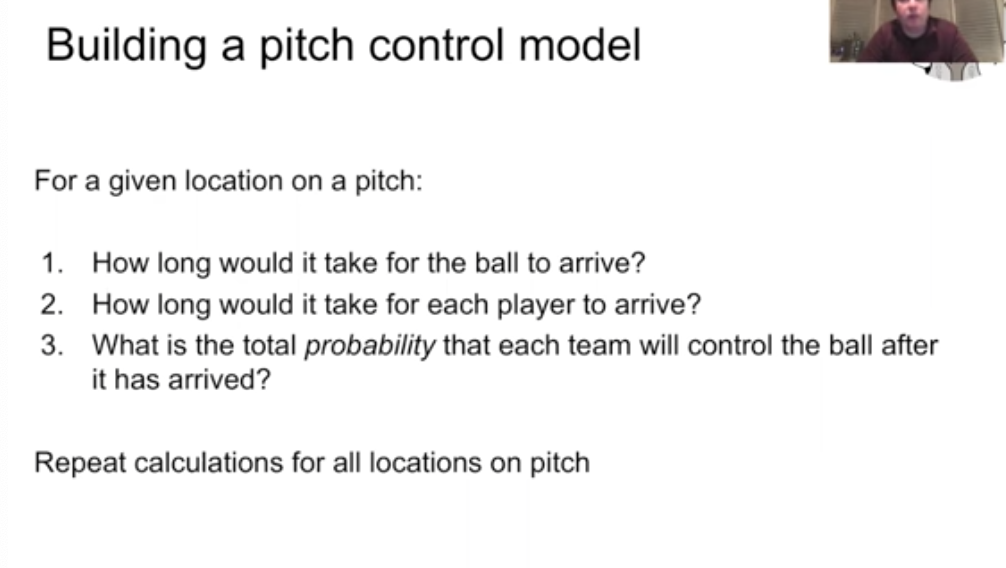

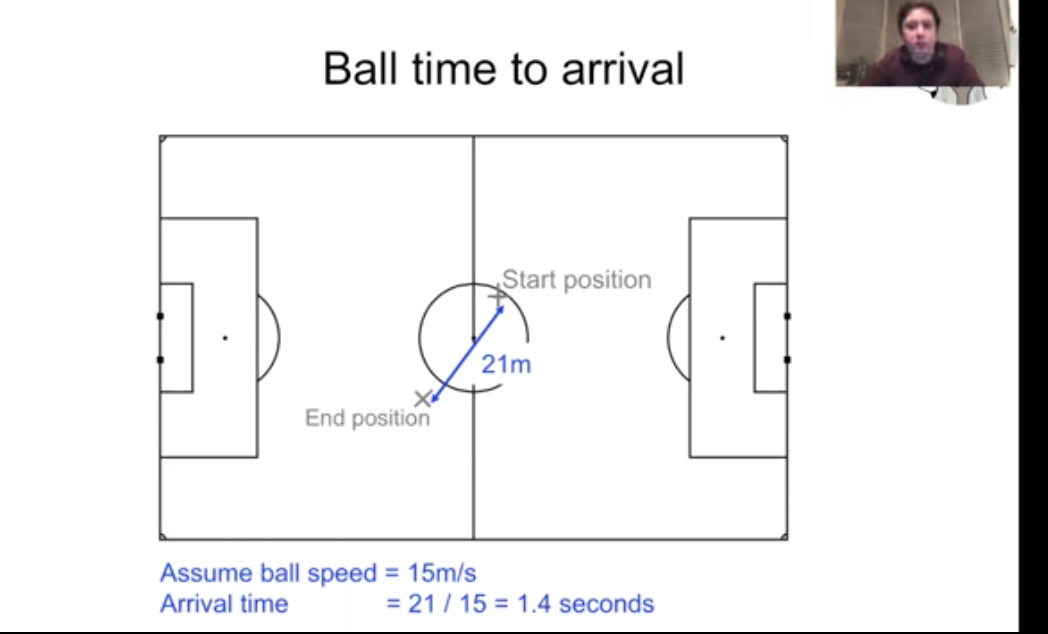

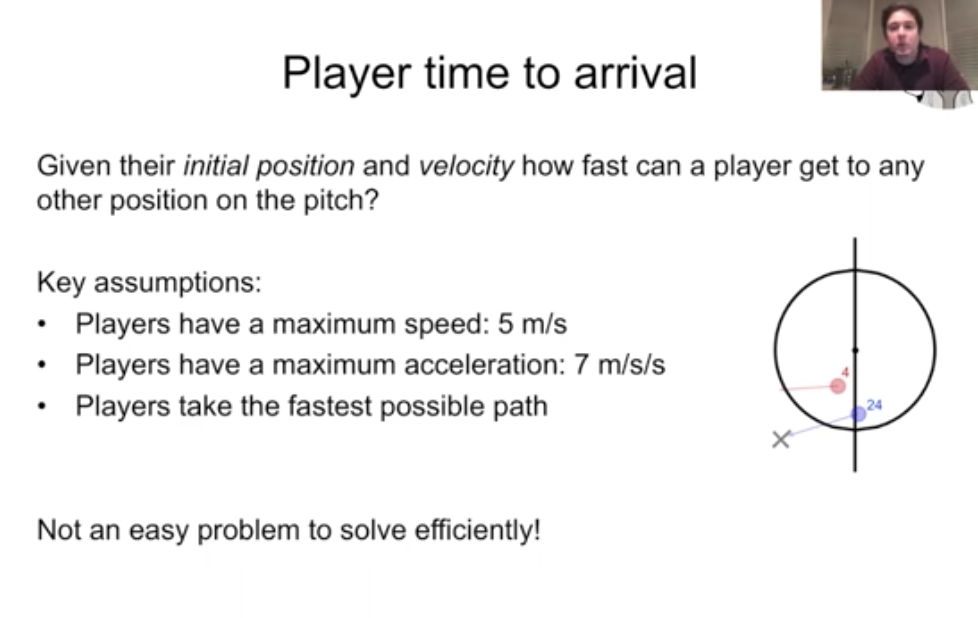

Max speed of 5m/s they will be going at to effectively control the ball

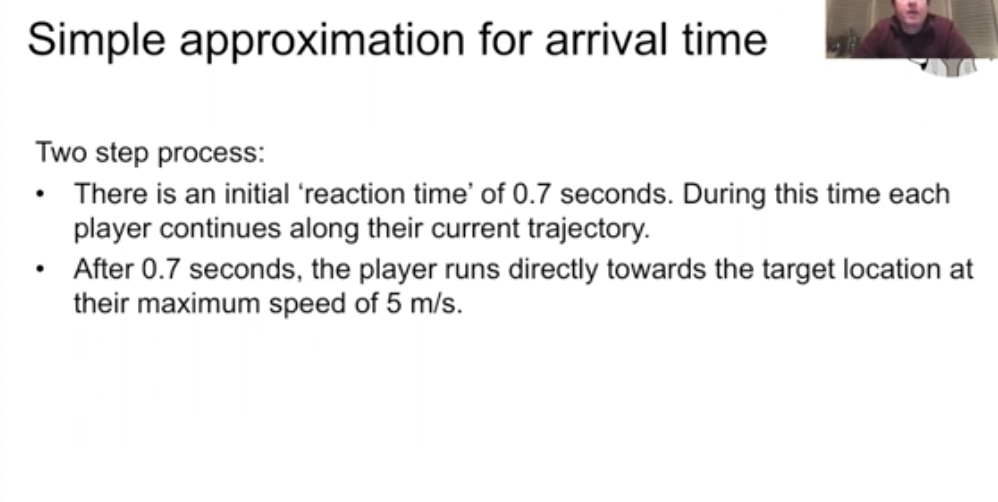

.7 seconds is roughly the amount of time it would take a player moving at their max speed to come to a complete halt

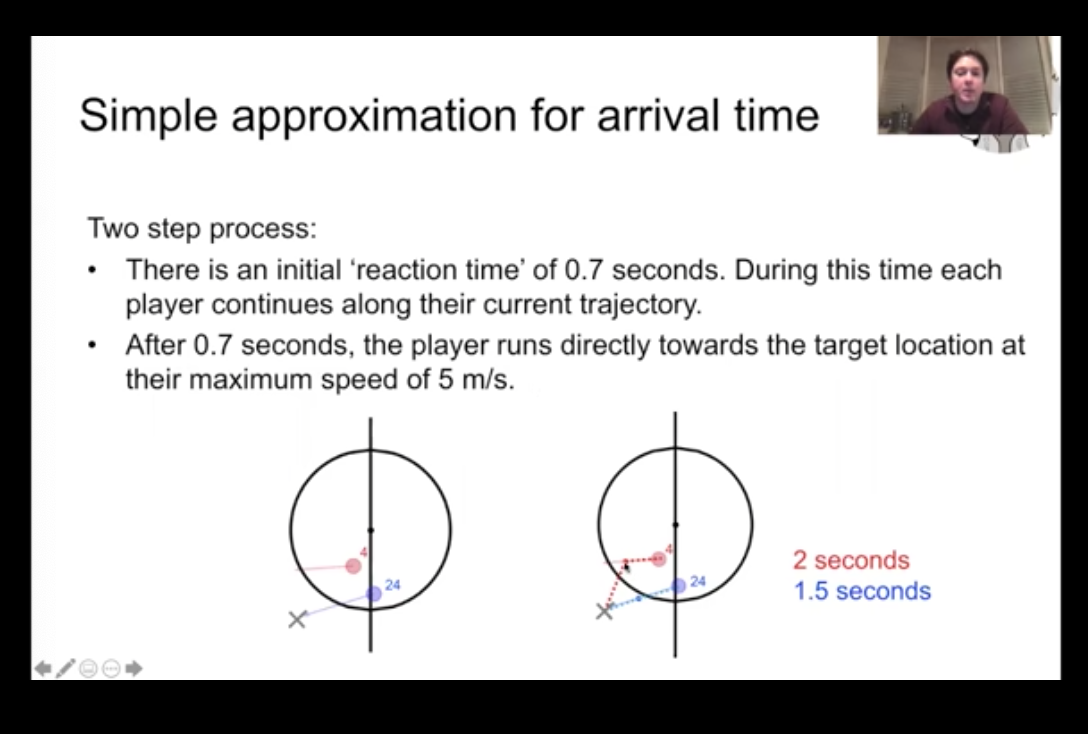

### How long would it take a player to actually control the ball

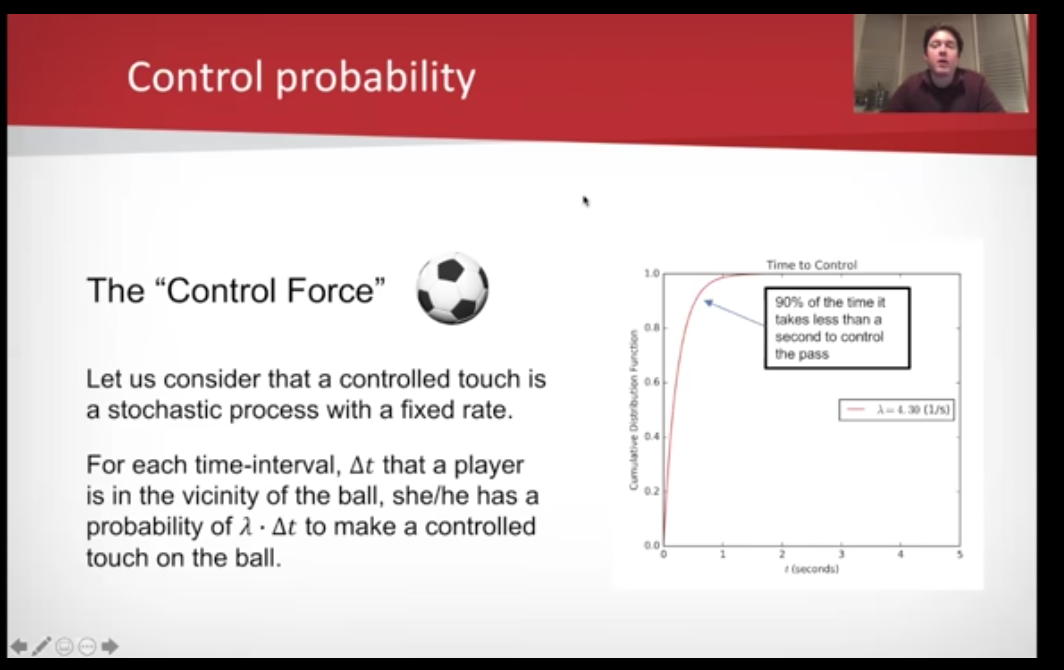

$\lambda$ is a free parameter within the model that determines how quickly footballers tend to control the ball.

4.3 1/seconds

ie. 90% of the time a player will have controlled the ball in under 1/5 a second

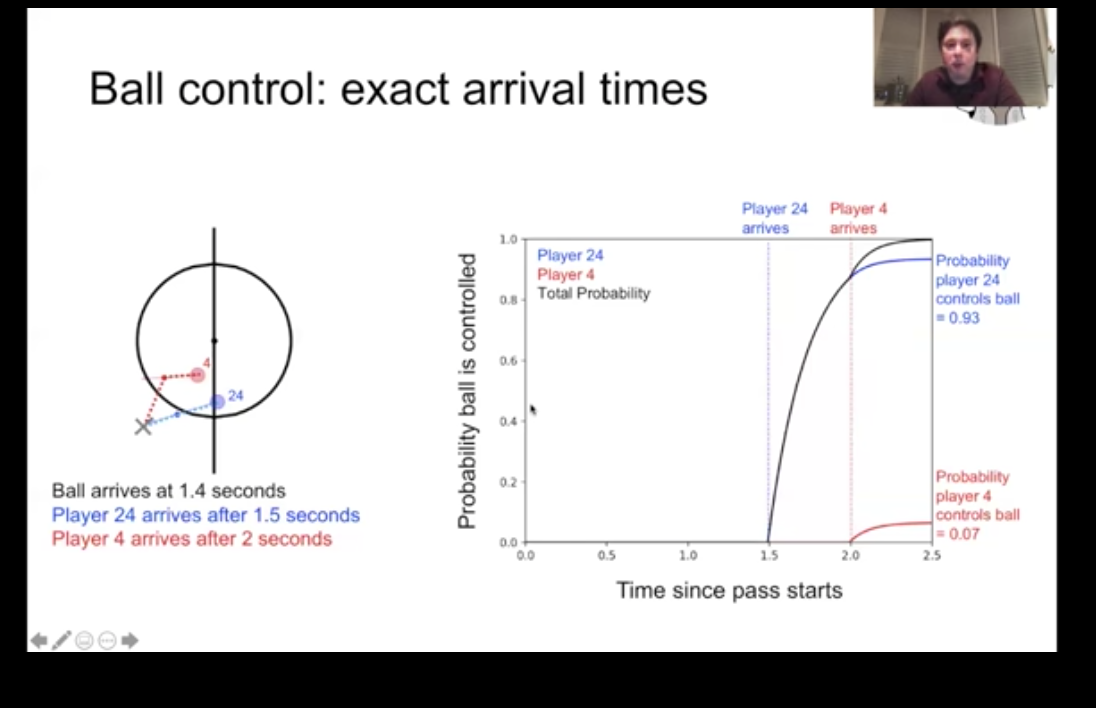

This assumes we know exactly when the player will arrive.

However, the model from William Spearman includes some uncertainty (using a sigmoid function)

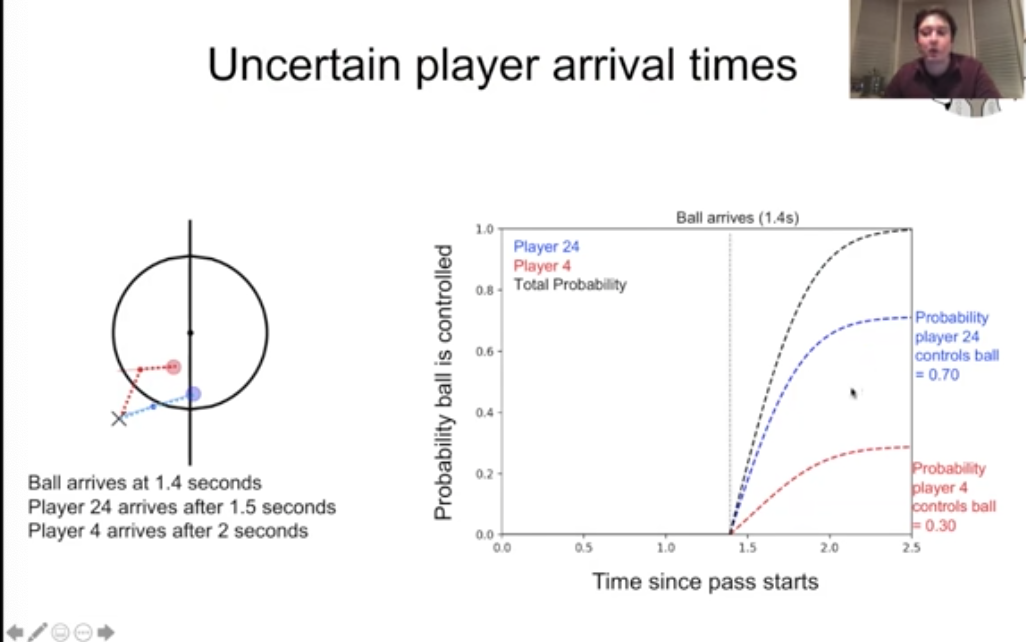

In [2]:
import sys  
sys.path.insert(0, '/Volumes/Transcend/DataScience/data_bootcamp/data/cap_data')

In [3]:
import Metrica_IO as mio
import Metrica_Viz_CF as mviz
import Metrica_Velocities_CF as mvel
import Metrica_PitchControl as mpc
import numpy as np


In [4]:
# set up initial path to data
DATADIR = "/Volumes/Transcend/DataScience/data_bootcamp/data/cap_data"
#DATADIR = '/Users/laurieshaw/Documents/Football/Data/TrackingData/Metrica/sample-data-master/data'

game_id = 2 # let's look at sample match 2



In [5]:
# read in the event data
events = mio.read_event_data(DATADIR,game_id)

# read in tracking data
tracking_home = mio.tracking_data(DATADIR,game_id,'Home')
tracking_away = mio.tracking_data(DATADIR,game_id,'Away')


Reading team: home
Reading team: away


In [6]:
# Convert positions from metrica units to meters (note change in Metrica's coordinate system since the last lesson)
tracking_home = mio.to_metric_coordinates(tracking_home)
tracking_away = mio.to_metric_coordinates(tracking_away)
events = mio.to_metric_coordinates(events)

# reverse direction of play in the second half so that home team is always attacking from right->left
tracking_home,tracking_away,events = mio.to_single_playing_direction(tracking_home,tracking_away,events)

# Calculate player velocities
tracking_home = mvel.calc_player_velocities(tracking_home,smoothing=True)
tracking_away = mvel.calc_player_velocities(tracking_away,smoothing=True)

In [8]:
# get all shots and goals in the match
shots = events[events['Type']=='SHOT']
goals = shots[shots['Subtype'].str.contains('-GOAL')].copy()

In [9]:
print(goals)

      Team  Type              Subtype  Period  Start Frame  Start Time [s]  \
198   Home  SHOT       ON TARGET-GOAL       1        12202          488.08   
823   Away  SHOT       ON TARGET-GOAL       1        53049         2121.96   
1118  Home  SHOT  HEAD-ON TARGET-GOAL       2        73983         2959.32   
1671  Away  SHOT       ON TARGET-GOAL       2       115009         4600.36   
1723  Home  SHOT       ON TARGET-GOAL       2       121027         4841.08   

      End Frame  End Time [s]      From   To  Start X  Start Y  End X  End Y  
198       12212        488.48  Player10  NaN   -47.70    -3.40 -54.06  -2.04  
823       53075       2123.00  Player24  NaN    44.52     2.72  54.06   1.36  
1118      73995       2959.80   Player9  NaN   -47.70     1.36 -54.06   2.04  
1671     115024       4600.96  Player20  NaN    40.28     1.36  55.12   2.72  
1723     121055       4842.20  Player12  NaN   -30.74     5.44 -54.06   2.72  


## Plot the 3 passes that lead up to that goal



(<Figure size 864x576 with 1 Axes>, <AxesSubplot:>)

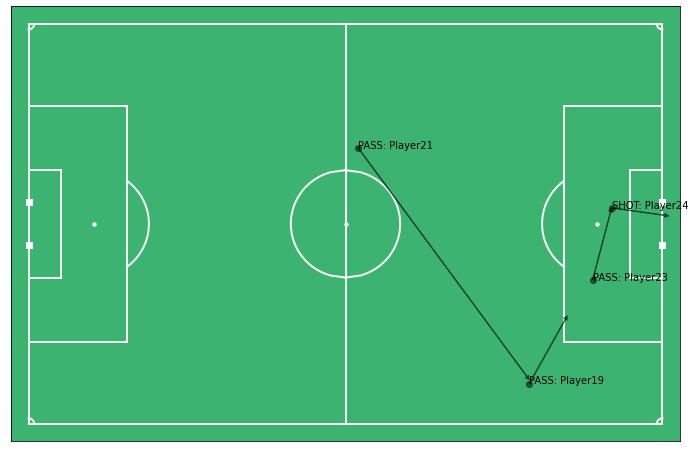

In [10]:
# plot the 3 events leading up to the second goal
mviz.plot_events( events.loc[820:823], color='k', indicators = ['Marker','Arrow'], annotate=True )

## Plot the pitch control field at the instant player 21 makes that pass

In [11]:
# first get pitch control model parameters
params = mpc.default_model_params()

In [12]:
print(params)

{'max_player_accel': 7.0, 'max_player_speed': 5.0, 'reaction_time': 0.7, 'tti_sigma': 0.45, 'kappa_def': 1.0, 'lambda_att': 4.3, 'lambda_def': 4.3, 'lambda_gk': 12.899999999999999, 'average_ball_speed': 15.0, 'int_dt': 0.04, 'max_int_time': 10, 'model_converge_tol': 0.01, 'time_to_control_att': 3.3202550055547313, 'time_to_control_def': 3.3202550055547313}


In [13]:
# find goalkeepers for offside calculation
GK_numbers = [mio.find_goalkeeper(tracking_home),mio.find_goalkeeper(tracking_away)]

(<Figure size 864x576 with 1 Axes>, <AxesSubplot:>)

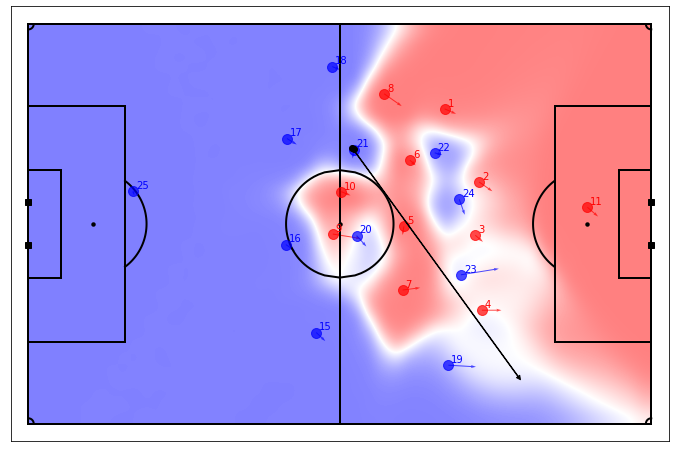

In [14]:
# evaluated pitch control surface for first pass
PPCF,xgrid,ygrid = mpc.generate_pitch_control_for_event(820, events, tracking_home, tracking_away, params, GK_numbers, field_dimen = (106.,68.,), n_grid_cells_x = 50)
mviz.plot_pitchcontrol_for_event( 820, events,  tracking_home, tracking_away, PPCF, annotate=True )

## NOTE
Get these plots in plotly so they are more interactive

(<Figure size 864x576 with 1 Axes>, <AxesSubplot:>)

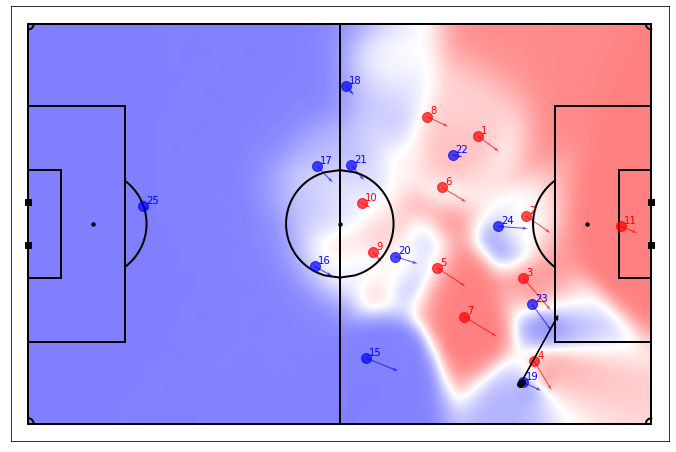

In [15]:
# evaluated pitch control surface for second pass
PPCF,xgrid,ygrid = mpc.generate_pitch_control_for_event(821, events, tracking_home, tracking_away, params, GK_numbers, field_dimen = (106.,68.,), n_grid_cells_x = 50)
mviz.plot_pitchcontrol_for_event( 821, events,  tracking_home, tracking_away, PPCF, annotate=True )


The opportunity of that pass (from 19 to 23) is really made by player 23's run to the ball to open up that space

(<Figure size 864x576 with 1 Axes>, <AxesSubplot:>)

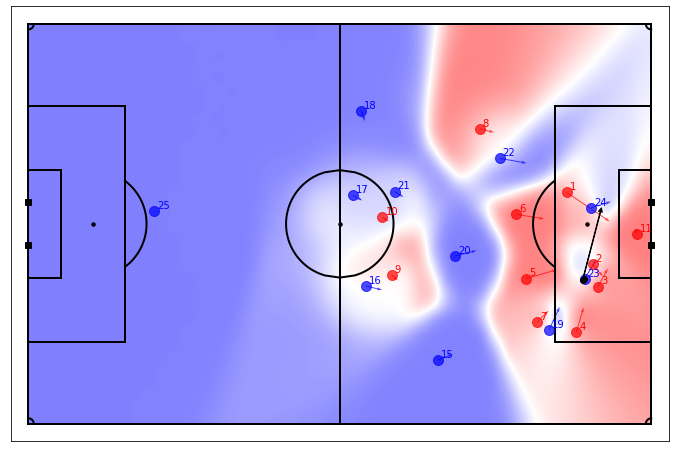

In [16]:
# evaluated pitch control surface for third pass
PPCF,xgrid,ygrid = mpc.generate_pitch_control_for_event(822, events, tracking_home, tracking_away, params, GK_numbers, field_dimen = (106.,68.,), n_grid_cells_x = 50)
mviz.plot_pitchcontrol_for_event( 822, events,  tracking_home, tracking_away, PPCF, annotate=True )


#### Looking at completed passes
- the unsuccessful passes, its difficult to determine which player the target is. It is possible, but difficult so for simplicity just looking at completed passes.

In [44]:
""" **** calculate pass probability for every home team succesful pass **** """
# get all home passes
home_passes = events[ (events['Type'].isin(['PASS'])) & (events['Team']=='Home') ]

# list for storing pass probablities
pass_success_probability = []

In [45]:
for i,row in home_passes.iterrows():
    pass_start_pos = np.array([row['Start X'],row['Start Y']])
    pass_target_pos = np.array([row['End X'],row['End Y']])
    pass_frame = row['Start Frame']
    
    attacking_players = mpc.initialise_players(tracking_home.loc[pass_frame],'Home',params, GK_numbers[0])
    defending_players = mpc.initialise_players(tracking_away.loc[pass_frame],'Away',params, GK_numbers[1])
    Patt,Pdef = mpc.calculate_pitch_control_at_target(pass_target_pos, attacking_players, defending_players, pass_start_pos, params)

    pass_success_probability.append( (i,Patt) )

Text(0, 0.5, 'Frequency')

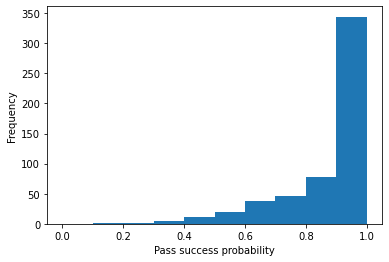

In [46]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots()
ax.hist( [p[1] for p in pass_success_probability], np.arange(0,1.1,0.1))    
ax.set_xlabel('Pass success probability')
ax.set_ylabel('Frequency')  


In [47]:
# sort the passes by pitch control probability
pass_success_probability = sorted( pass_success_probability, key = lambda x: x[1] )

# identify the events corresponding to the most risky passes (pitch control < 0.5)
risky_passes = events.loc[ [p[0] for p in pass_success_probability if p[1]<0.5 ] ]


(<Figure size 864x576 with 1 Axes>, <AxesSubplot:>)

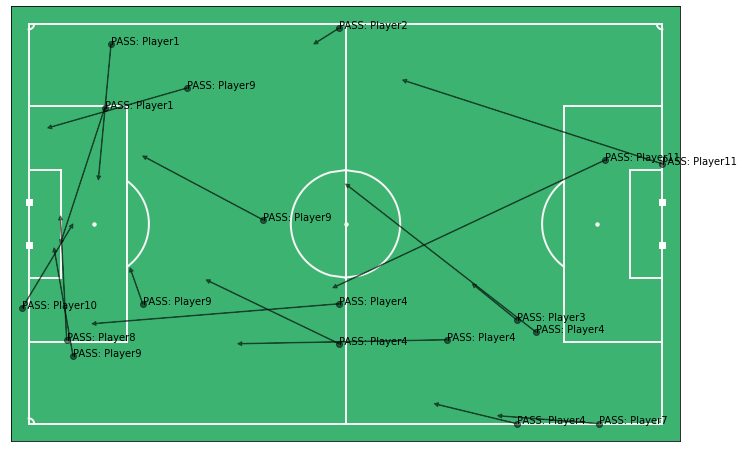

In [48]:
# plot the events
mviz.plot_events( risky_passes, color='k', indicators = ['Marker','Arrow'], annotate=True )


In [49]:
# Print events that followed those risky passes
print("Event following a risky (completed) pass")
for p in pass_success_probability[:20]:
    outcome = events.loc[ p[0]+1 ].Type
    print( p[1], outcome )

Event following a risky (completed) pass
0.16032323299177353 BALL LOST
0.1613295457364334 CHALLENGE
0.21206157666402636 SHOT
0.31160841865474626 CHALLENGE
0.33190526185319885 SHOT
0.33704347298090714 CHALLENGE
0.36392839076897665 BALL LOST
0.413156252316369 CHALLENGE
0.4204267746341931 PASS
0.4312712628523871 CHALLENGE
0.44435098489183955 CHALLENGE
0.44844895551994096 PASS
0.4593665151483775 CHALLENGE
0.46181533356257487 SHOT
0.468048170879984 CHALLENGE
0.4897275563912591 CHALLENGE
0.4900872646495704 CHALLENGE
0.4917205100922212 SHOT
0.5001349056944236 PASS
0.5026909720011078 PASS


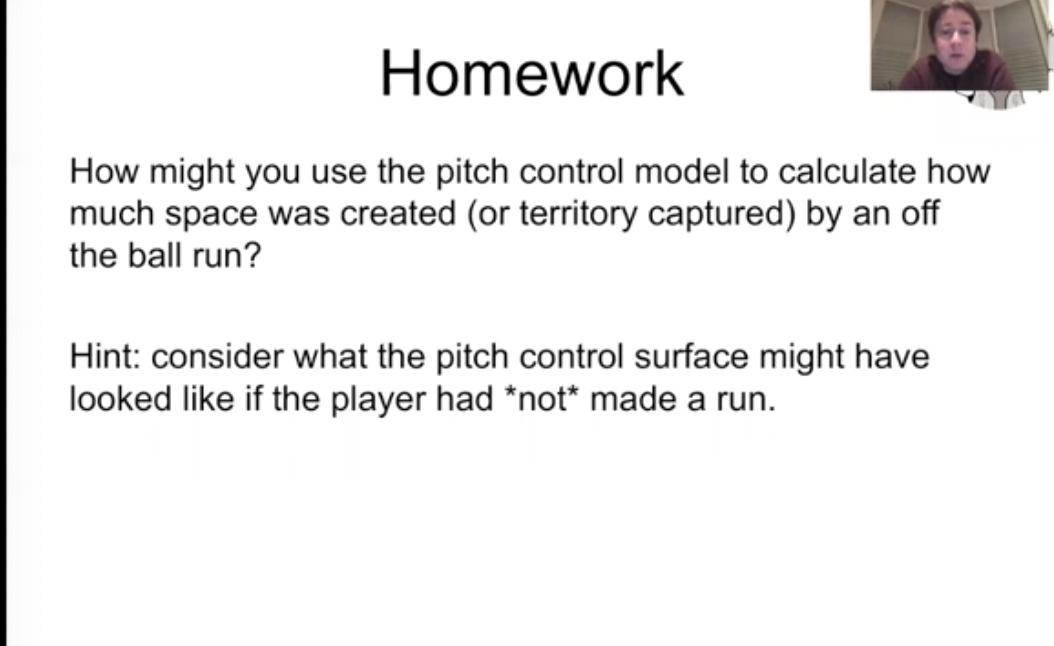



Quantify actions of players off the ball